In [1]:
import pandas as pd

In [2]:
agent_df = pd.read_pickle('agent_output_NO_PROMO.pkl')
joint_calendar_df = pd.read_pickle('joint_calendar_NO_PROMO.pkl')

In [3]:
# Reset index and move it to columns
agent_df = agent_df.reset_index()

# Subtract 52 from 'Step' column to start from 0
agent_df['Step'] = agent_df['Step'] - 52

# Set 'Step' and 'AgentID' back as indices
agent_df.set_index(['Step', 'AgentID'], inplace=True)

# Reset index and move it to columns
agent_df_reset = agent_df.reset_index()

# Create a date range starting from '2021-01-03' with a frequency of one week
# The number of periods is the number of unique 'Step' values in agent_df
dates = pd.date_range(start='2021-01-03', periods=agent_df_reset['Step'].nunique(), freq='W')

# Create a DataFrame mapping 'Step' to 'Date'
step_to_date = pd.DataFrame({'Step': range(0, len(dates)), 'Date': dates})

# Merge this DataFrame with agent_df to add the 'Date' column
agent_df_reset = agent_df_reset.merge(step_to_date, on='Step')

# Set 'Step' and 'AgentID' back as indices
agent_df = agent_df_reset.set_index(['Step', 'AgentID'])

In [4]:
joint_calendar_df = joint_calendar_df[52:].reset_index(drop=True)

In [5]:
def calculate_total_purchases(agent_df):
    '''
    Computes total purchases per brand per step from agent level output
    Used as sanity check for model level output
    '''
    # Initialize empty lists to store the results
    total_purchases_A = []
    total_purchases_B = []
    dates = []
    steps = []

    # Iterate over the 'Purchased_This_Step' column
    for index, row in agent_df.iterrows():
        # Append the number of purchases for each brand to the respective list
        total_purchases_A.append(row['Purchased_This_Step']['A'])
        total_purchases_B.append(row['Purchased_This_Step']['B'])
        dates.append(row['Date'])
        steps.append(index[0])  # Assuming 'Step' is the first level of the index

    # Create a new DataFrame with the total purchases for each brand
    total_purchases_df = pd.DataFrame({
        'Total_Purchases_A': total_purchases_A,
        'Total_Purchases_B': total_purchases_B,
        'Date': dates,
    })

    # Group by 'Date' and 'Step' and sum the purchases
    total_purchases_df = total_purchases_df.groupby(['Date']).sum().reset_index()

    return total_purchases_df

In [6]:
total_purchases_df = calculate_total_purchases(agent_df)

In [7]:
# Calculate total dollar sales for Brand A and Brand B and add them to the total_purchases_df
# Also add price, tv and web ad spend columns for A and B to the total_purchases_df dataframe
total_purchases_df['Price_A'] = joint_calendar_df[('A', 'price')]
total_purchases_df['Price_B'] = joint_calendar_df[('B', 'price')]
total_purchases_df['TV_A'] = joint_calendar_df[('A', 'TV')]
total_purchases_df['Web_A'] = joint_calendar_df[('A', 'Web')]
total_purchases_df['TV_B'] = joint_calendar_df[('B', 'TV')]
total_purchases_df['Web_B'] = joint_calendar_df[('B', 'Web')]
total_purchases_df['Total_Sales_A'] = total_purchases_df['Total_Purchases_A'] * total_purchases_df['Price_A']
total_purchases_df['Total_Sales_B'] = total_purchases_df['Total_Purchases_B'] * total_purchases_df['Price_B']


In [8]:
# Set correct data types
total_purchases_df['Price_A'] = total_purchases_df['Price_A'].astype(float)
total_purchases_df['Price_B'] = total_purchases_df['Price_B'].astype(float)
total_purchases_df['Total_Purchases_A'] = total_purchases_df['Total_Purchases_A'].astype(float)
total_purchases_df['Total_Purchases_B'] = total_purchases_df['Total_Purchases_B'].astype(float)
total_purchases_df['Total_Sales_A'] = total_purchases_df['Total_Sales_A'].astype(float)
total_purchases_df['Total_Sales_B'] = total_purchases_df['Total_Sales_B'].astype(float)
total_purchases_df['TV_A'] = total_purchases_df['TV_A'].astype(float)
total_purchases_df['Web_A'] = total_purchases_df['Web_A'].astype(float)
total_purchases_df['TV_B'] = total_purchases_df['TV_B'].astype(float)
total_purchases_df['Web_B'] = total_purchases_df['Web_B'].astype(float)

In [9]:
data_A = total_purchases_df[['Date','Total_Sales_A','TV_A','Web_A']]

In [10]:
import pymc_marketing as pmm

# Define the columns
date_column = 'Date'
channel_columns = ['TV_A', 'Web_A']

my_sampler_config = {
    'tune': 1000,
    'draws': 1000,
    'chains': 4,
    #'target_accept': 0.9  # Increase this value to increase target_accept
}

# Instantiate the model
mmm = pmm.mmm.delayed_saturated_mmm.DelayedSaturatedMMM(
    sampler_config=my_sampler_config,
    date_column=date_column,
    channel_columns=channel_columns,
    adstock_max_lag=8,
    yearly_seasonality=None
)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [11]:
# Split data into predictors (X) and target (y)
X = data_A.drop('Total_Sales_A', axis=1)
y = data_A['Total_Sales_A']

# Fit the model
mmm.fit(X, y)

/Users/MikeFitzgerald/venvs/pymc/lib/python3.11/site-packages/pymc/model/core.py:518: FutureWarning: All coords are now mutable by default. coords_mutable will be removed in a future release.
  warnings.warn(
/Users/MikeFitzgerald/venvs/pymc/lib/python3.11/site-packages/pymc/model/core.py:981: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(
/Users/MikeFitzgerald/venvs/pymc/lib/python3.11/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, likelihood_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

In [12]:
import arviz as az
import pymc as pm
import seaborn as sns

In [13]:
mmm.fit_result

<xarray.Dataset> Size: 47MB
Dimensions:                    (chain: 4, draw: 1000, channel: 2, date: 208)
Coordinates:
  * chain                      (chain) int64 32B 0 1 2 3
  * draw                       (draw) int64 8kB 0 1 2 3 4 ... 996 997 998 999
  * channel                    (channel) <U5 40B 'TV_A' 'Web_A'
  * date                       (date) datetime64[ns] 2kB 2021-01-03 ... 2024-...
Data variables:
    alpha                      (chain, draw, channel) float64 64kB 0.9051 ......
    beta_channel               (chain, draw, channel) float64 64kB 0.1083 ......
    channel_adstock            (chain, draw, date, channel) float64 13MB 0.0 ...
    channel_adstock_saturated  (chain, draw, date, channel) float64 13MB 0.0 ...
    channel_contributions      (chain, draw, date, channel) float64 13MB 0.0 ...
    intercept                  (chain, draw) float64 32kB 0.8144 ... 0.8155
    lam                        (chain, draw, channel) float64 64kB 6.083 ... ...
    likelihood_sigma           (chain, draw) float64 32kB 0.0626 ... 0.06431
    mu                         (chain, draw, date) float64 7MB 0.8144 ... 0.8155
Attributes:
    created_at:                 2024-05-28T15:24:31.066412+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.13.1
    sampling_time:              6.173365116119385
    tuning_steps:               1000

In [15]:
az.summary(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "likelihood_sigma",
        "beta_channel",
        "alpha",
        "lam",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.822,0.005,0.812,0.832,0.000,0.000,2905.0,2693.0,1.00
likelihood_sigma,0.061,0.003,0.055,0.066,0.000,0.000,3284.0,2897.0,1.00
beta_channel[TV_A],0.217,0.191,0.075,0.504,0.007,0.005,1093.0,935.0,1.00
beta_channel[Web_A],0.222,0.187,0.091,0.503,0.006,0.005,1163.0,1019.0,1.01
alpha[TV_A],0.946,0.029,0.894,0.992,0.001,0.000,2531.0,1768.0,1.00
alpha[Web_A],0.931,0.033,0.873,0.988,0.001,0.000,2642.0,2023.0,1.00
lam[TV_A],3.925,2.176,0.309,7.615,0.058,0.041,1167.0,865.0,1.00
lam[Web_A],4.195,2.319,0.379,8.206,0.060,0.043,1186.0,1025.0,1.00


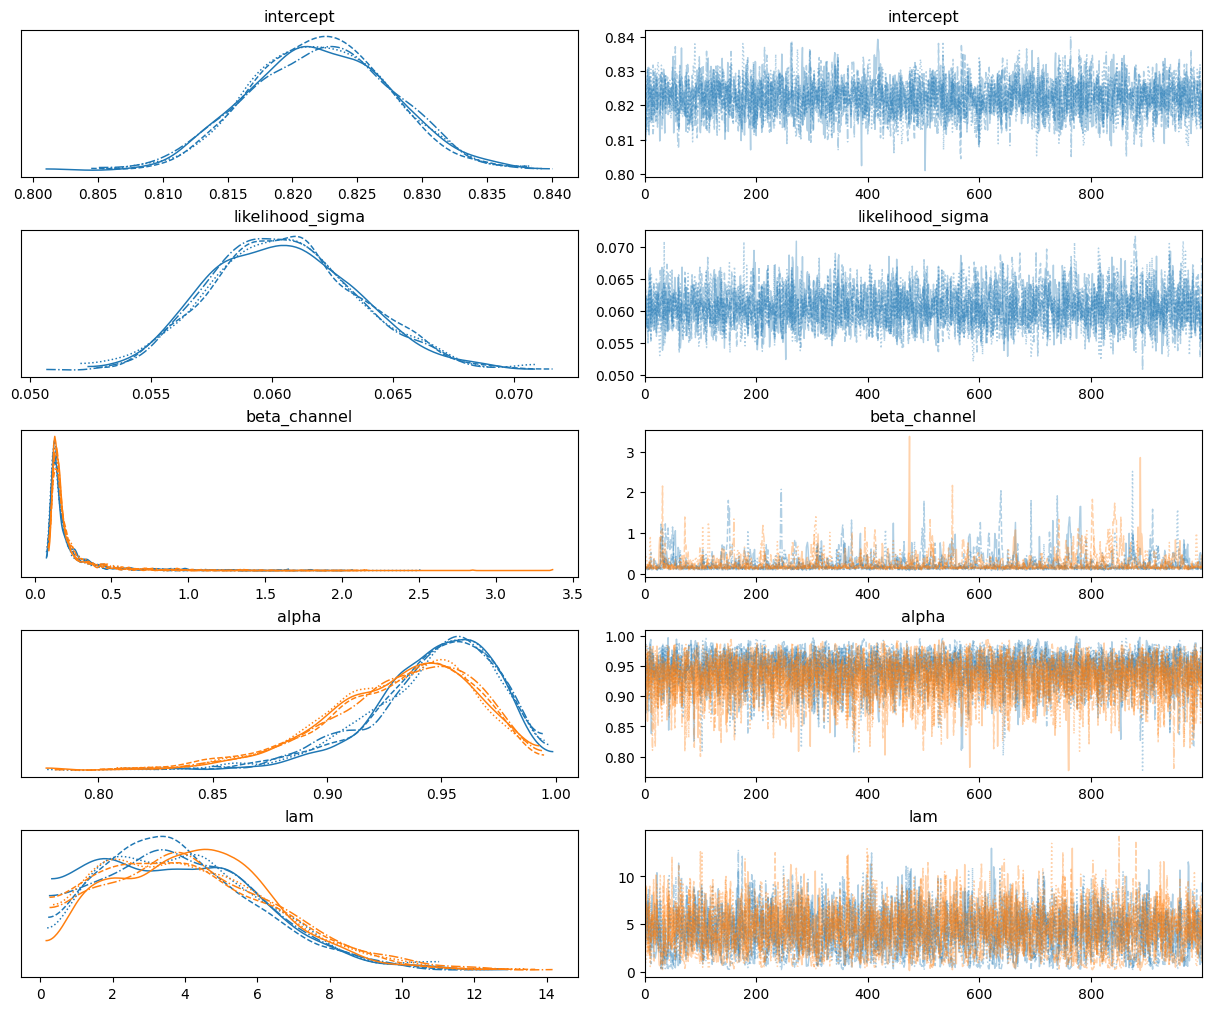

In [16]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "likelihood_sigma",
        "beta_channel",
        "alpha",
        "lam",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)

In [17]:
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)

Sampling: [y]


Output()

<xarray.Dataset> Size: 7MB
Dimensions:  (date: 208, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 2kB 2021-01-03 2021-01-10 ... 2024-12-22
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 7MB 2.352e+03 2.535e+03 ... 2.759e+03
Attributes:
    created_at:                 2024-05-28T15:24:48.932944+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.13.1

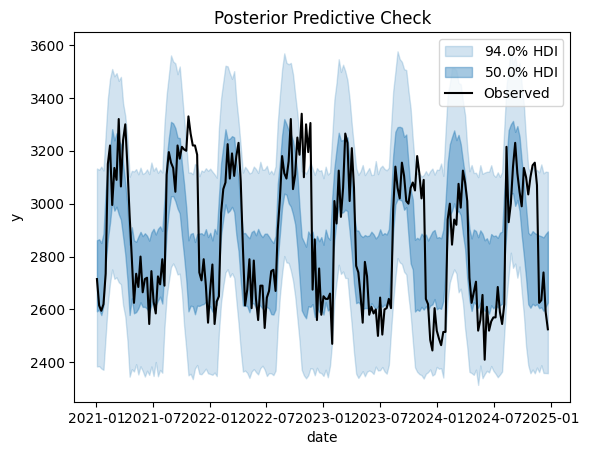

In [18]:
mmm.plot_posterior_predictive(original_scale=True);

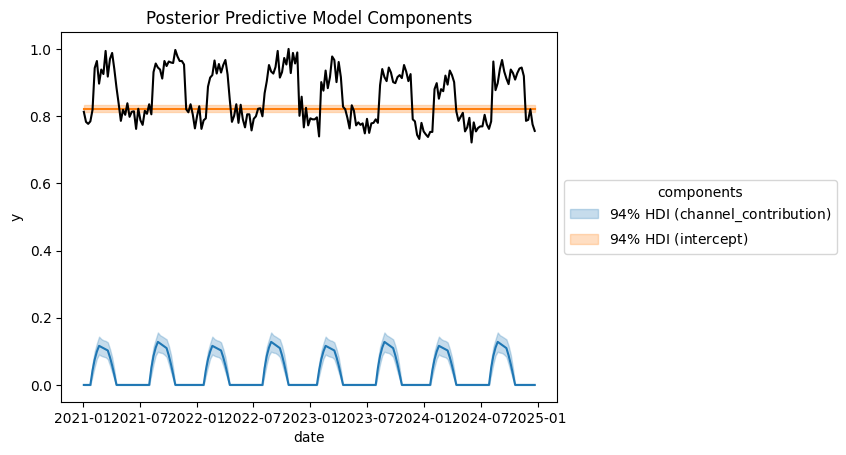

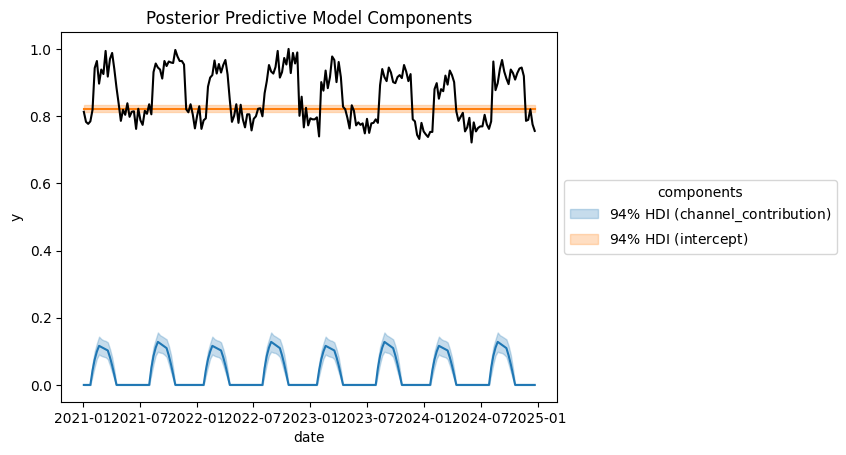

In [19]:
mmm.plot_components_contributions()

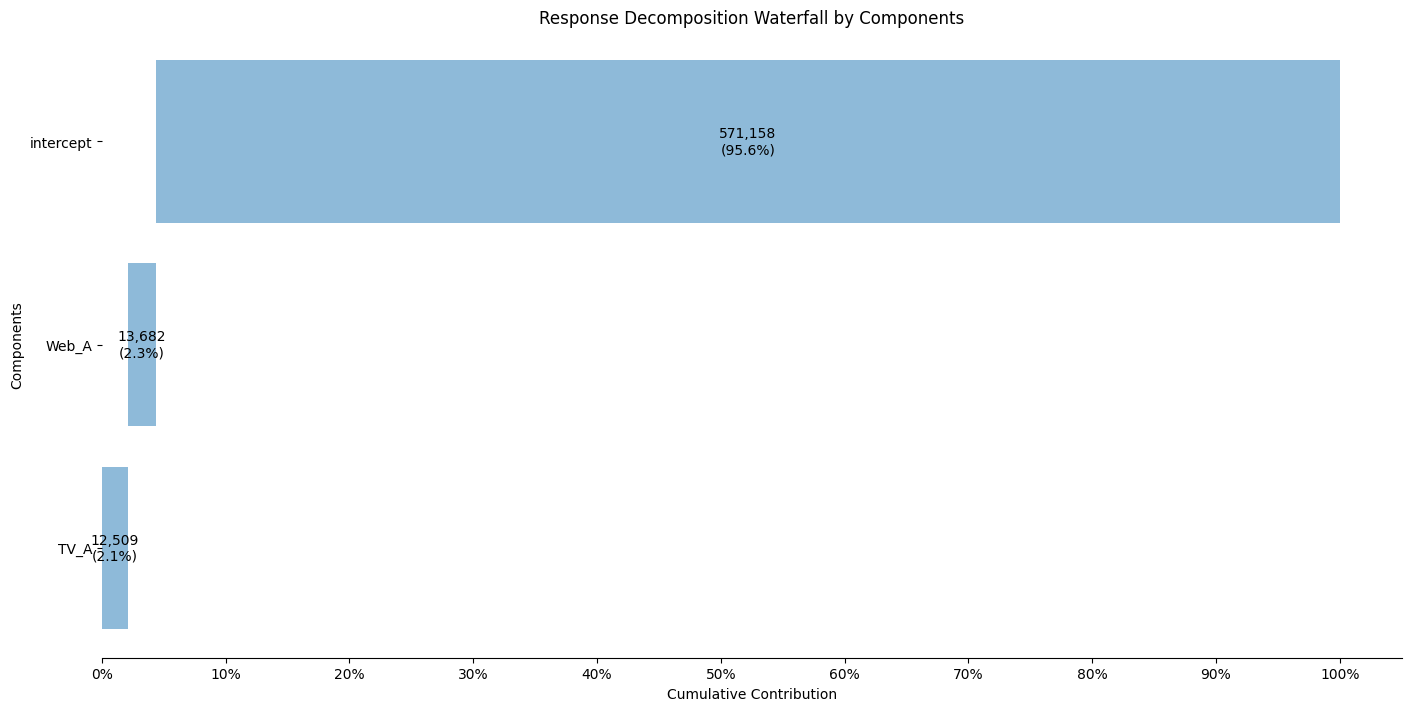

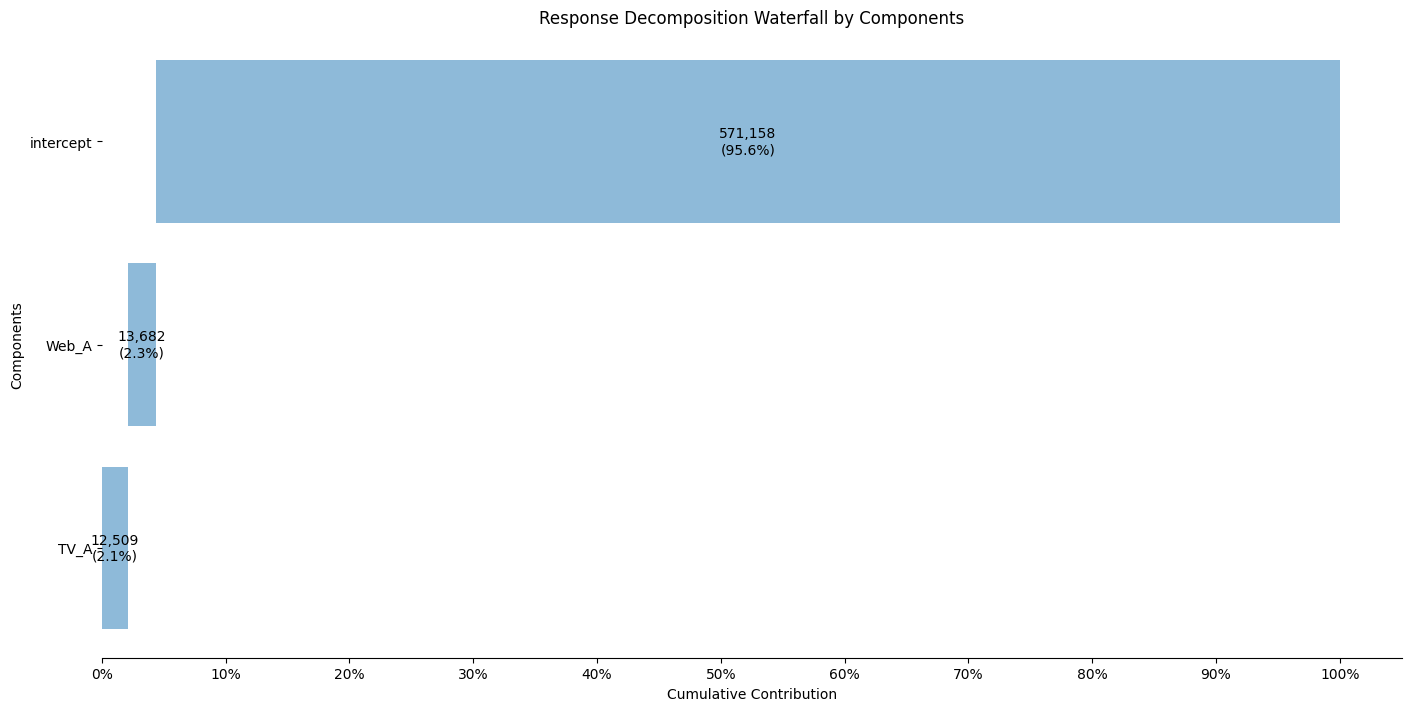

In [20]:
mmm.plot_waterfall_components_decomposition()

In [29]:
import pprint

In [30]:
dummy_model = DelayedSaturatedMMM(date_column="", channel_columns="", adstock_max_lag=4)
pprint.pprint(dummy_model.default_model_config)

{'alpha': {'dist': 'Beta', 'kwargs': {'alpha': 1, 'beta': 3}},
 'beta_channel': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}},
 'gamma_control': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'gamma_fourier': {'dist': 'Laplace', 'kwargs': {'b': 1, 'mu': 0}},
 'intercept': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'lam': {'dist': 'Gamma', 'kwargs': {'alpha': 3, 'beta': 1}},
 'likelihood': {'dist': 'Normal',
                'kwargs': {'sigma': {'dist': 'HalfNormal',
                                     'kwargs': {'sigma': 2}}}}}
